### 2-Asset Efficient Frontier

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import risk_kit as rk
import pandas as pd
import numpy as np

In [24]:
ind=rk.get_ind_returns()
er=rk.ann_returns(ind["1996":"2000"])
er

Food     0.116799
Beer     0.141126
Smoke    0.107830
Games    0.068212
Books    0.187286
Hshld    0.134766
Clths    0.079160
Hlth     0.246641
Chems    0.077456
Txtls   -0.042721
Cnstr    0.084076
Steel    0.115809
FabPr    0.108280
ElcEq    0.272420
Autos    0.080954
Carry    0.173904
Mines   -0.053554
Coal     0.414689
Oil      0.165377
Util     0.145903
Telcm    0.122771
Servs    0.175264
BusEq    0.271952
Paper    0.097163
Trans    0.071099
Whlsl    0.126431
Rtail    0.207247
Meals    0.067400
Fin      0.223371
Other    0.043349
dtype: float64

In [3]:
cov=ind["1996":"2000"].cov()

In [4]:
def portfolio_return(weights,returns):
    return np.Transpose(weights) @ returns
    
def portfolio_vol(weights, covmat):
    return (weights.T @ covmat @ weights)**0.5

In [5]:
l=["Food","Beer","Smoke","Coal"]
er[l]

Food     0.116799
Beer     0.141126
Smoke    0.107830
Coal     0.414689
dtype: float64

In [6]:
cov.loc[l,l]

,Food,Beer,Smoke,Coal
Food,0.002609,0.002379,0.002061,0.000027
Beer,0.002379,0.005264,0.001359,0.001728
Smoke,0.002061,0.001359,0.008349,-0.000733
Coal,0.000027,0.001728,-0.000733,0.018641


In [7]:
weights=[1/len(l)]*4

In [8]:
weights

[0.25, 0.25, 0.25, 0.25]

In [9]:
rk.portfolio_return(weights,er[l])

0.19511097196038385

In [10]:
rk.portfolio_vol(weights,cov.loc[l,l])

0.055059195776437045

### 2 Asset Frontier

In [11]:
l=["Games","Fin"]

In [12]:
n_points=20
weights_new=[np.array([w,1-w]) for w in np.linspace(0,1,n_points)]

In [13]:
weights_new

[array([0., 1.]),
 array([0.05263158, 0.94736842]),
 array([0.10526316, 0.89473684]),
 array([0.15789474, 0.84210526]),
 array([0.21052632, 0.78947368]),
 array([0.26315789, 0.73684211]),
 array([0.31578947, 0.68421053]),
 array([0.36842105, 0.63157895]),
 array([0.42105263, 0.57894737]),
 array([0.47368421, 0.52631579]),
 array([0.52631579, 0.47368421]),
 array([0.57894737, 0.42105263]),
 array([0.63157895, 0.36842105]),
 array([0.68421053, 0.31578947]),
 array([0.73684211, 0.26315789]),
 array([0.78947368, 0.21052632]),
 array([0.84210526, 0.15789474]),
 array([0.89473684, 0.10526316]),
 array([0.94736842, 0.05263158]),
 array([1., 0.])]

In [14]:
rets=[rk.portfolio_return(w,er[l]) for w in weights_new]
vols=[rk.portfolio_vol(w, cov.loc[l,l]) for w in weights_new]

In [18]:
df=pd.DataFrame({"Returns": rets,"Vol": vols})
df

,Returns,Vol
0,0.223371,0.063100
1,0.215205,0.061845
2,0.207039,0.060699
3,0.198873,0.059666
4,0.190706,0.058753
5,0.182540,0.057965
6,0.174374,0.057308
7,0.166207,0.056786
8,0.158041,0.056403
9,0.149875,0.056161


<Axes: xlabel='Vol'>

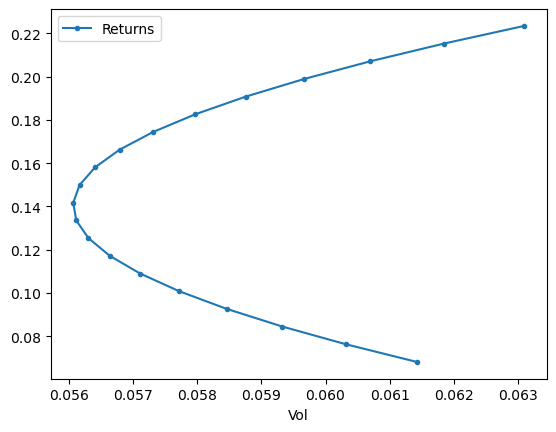

In [19]:
df.plot(x="Vol",y="Returns", style=".-")

### N-Asset Efficient Frontier

In [20]:
from scipy.optimize import minimize

In [23]:
er.shape

(30,)

In [30]:


def minimize_vol(target_return, er,cov):
    n=er.shape[0]
    init_guess= np.repeat(1/n,n)
    #constraints 
    bounds=((0.0,1.0),)*n   #tuple of tuples
    return_is_target={
        'type':'eq',
        'args':(er,),
        'fun': lambda weights,er: target_return - rk.portfolio_return(weights,er)
    }
    weights_sum_to_1= {
        'type': 'eq',
        'fun': lambda weights : np.sum(weights)-1
    }
    
    results = minimize(rk.portfolio_vol, init_guess, args=(cov,), method="SLSQP",
                      options={'disp':False}, constraints=(return_is_target, weights_sum_to_1),
                       bounds=bounds)
    return results.x

In [31]:
w15=minimize_vol(0.15, er[l],cov.loc[l,l])
vol15=rk.portfolio_vol(w15,cov.loc[l,l])
vol15

0.056163669406706564

In [32]:
w15

array([0.47287631, 0.52712369])

In [36]:
l2=['Food','Beer','Smoke','Games']
w15=minimize_vol(0.15,er[l2],cov.loc[l2,l2])
vol15=rk.portfolio_vol(w15,cov.loc[l2,l2])
vol15

0.07255448379421382

In [44]:
def optimal_weights(n_points,er, cov):
    target_rs=np.linspace(er.min(), er.max(), n_points)
    weights=[minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

In [47]:
def plot_ef(n_points,er, cov):
    "Plots the multi-asset efficient frontier"
    weights=optimal_weights(n_points,er,cov)
    rets=[rk.portfolio_return(w,er) for w in weights]
    vols=[rk.portfolio_vol(w,cov) for w in weights]
    ef=pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility",y="Returns",style='.-')


<Axes: xlabel='Volatility'>

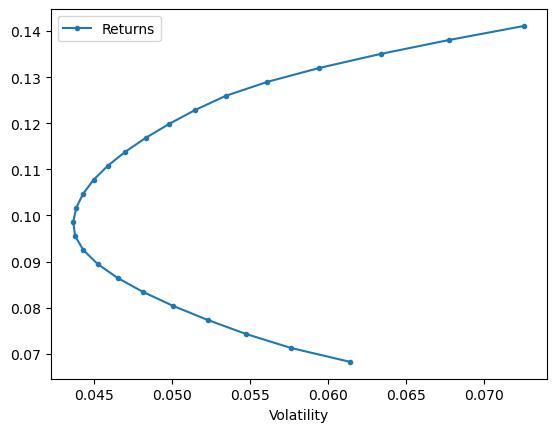

In [48]:
plot_ef(25,er[l2],cov.loc[l2,l2])

<Axes: xlabel='Volatility'>

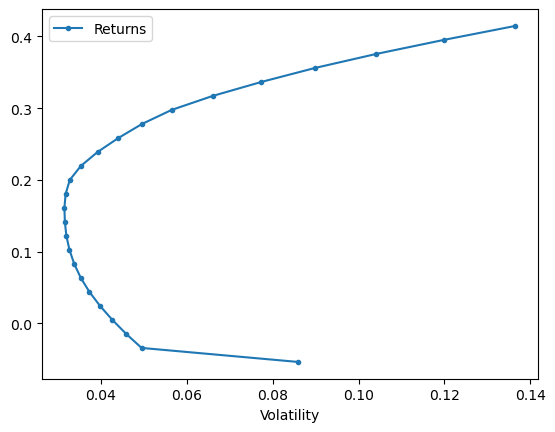

In [49]:
rk.plot_ef(25,er,cov)